In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-08-13 15:21:58.256261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 15:22:07.371511: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-13 15:22:40.923551: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [29]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHs=50

In [30]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [31]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [32]:
len(dataset)

68

2023-08-12 12:08:14.930432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 12:08:14.931726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 12:08:16.217759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]


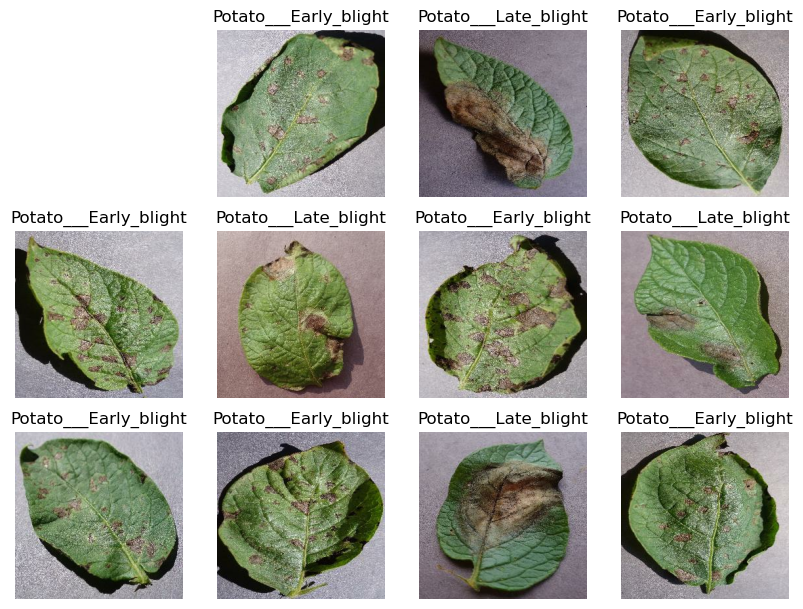

In [33]:
plt.figure(figsize=(10,10))
for i in range(1, 12):
    for image_batch, label_batch in dataset.take(1):
        ax = plt.subplot(4,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")

In [34]:
train_size = 0.8
train_number = int(len(dataset)*train_size)

In [35]:
train_ds = dataset.take(train_number)
len(train_ds)

54

In [36]:
test_ds = dataset.skip(train_number)
len(test_ds)

14

In [37]:
# Validation
val_size=0.1
val_number = int(len(dataset)*val_size)
val_number

6

In [38]:
# Actial test dataset
test_ds = test_ds.skip(val_number)
len(test_ds)

8

In [39]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_size=10000, shuffle=True):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

54

In [42]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
resize_and_rescale = tf.keras.Sequential([
   layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
   layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [46]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [47]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
     resize_and_rescale,
     data_augmentation,
     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
     layers.MaxPool2D((2,2)),
    
     layers.Conv2D(64, (3,3), activation='relu'),
     layers.MaxPool2D((2,2)), 
    layers.Conv2D(32, (3,3), activation='relu'),
     layers.MaxPool2D((2,2)), 
    layers.Conv2D(32, (3,3), activation='relu'),
     layers.MaxPool2D((2,2)), 
    layers.Conv2D(32, (3,3), activation='relu'),
     layers.MaxPool2D((2,2)), 
    layers.Conv2D(32, (3,3), activation='relu'),
     layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.build(input_shape=input_shape)


In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [50]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_ds,
    epochs=EPOCHs,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50


2023-08-12 12:18:37.303830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 12:18:37.306225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.5538

2023-08-12 12:22:03.146922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]
2023-08-12 12:22:03.148724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


54/54 [==============================] - 214s 4s/step - loss: 0.8677 - accuracy: 0.5538 - val_loss: 0.6729 - val_accuracy: 0.7031
Epoch 2/50
54/54 [==============================] - 203s 4s/step - loss: 0.4943 - accuracy: 0.7755 - val_loss: 0.3717 - val_accuracy: 0.8646
Epoch 3/50
54/54 [==============================] - 198s 4s/step - loss: 0.3195 - accuracy: 0.8744 - val_loss: 0.2166 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 196s 4s/step - loss: 0.3121 - accuracy: 0.8785 - val_loss: 0.2571 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 196s 4s/step - loss: 0.2860 - accuracy: 0.8866 - val_loss: 0.1859 - val_accuracy: 0.9271
Epoch 6/50
54/54 [==============================] - 195s 4s/step - loss: 0.1892 - accuracy: 0.9282 - val_loss: 0.3641 - val_accuracy: 0.8750
Epoch 7/50
54/54 [==============================] - 195s 4s/step - loss: 0.1745 - accuracy: 0.9311 - val_loss: 0.2914 - val_accuracy: 0.8594
Epoch 8/50
54/54 [======

In [52]:
scores = model.evaluate(test_ds)

2023-08-12 19:44:52.221616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 19:44:52.223350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


8/8 [==============================] - 15s 1s/step - loss: 0.0250 - accuracy: 0.9922


In [53]:
scores

[0.024959737434983253, 0.9921875]

In [54]:
history

In [55]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

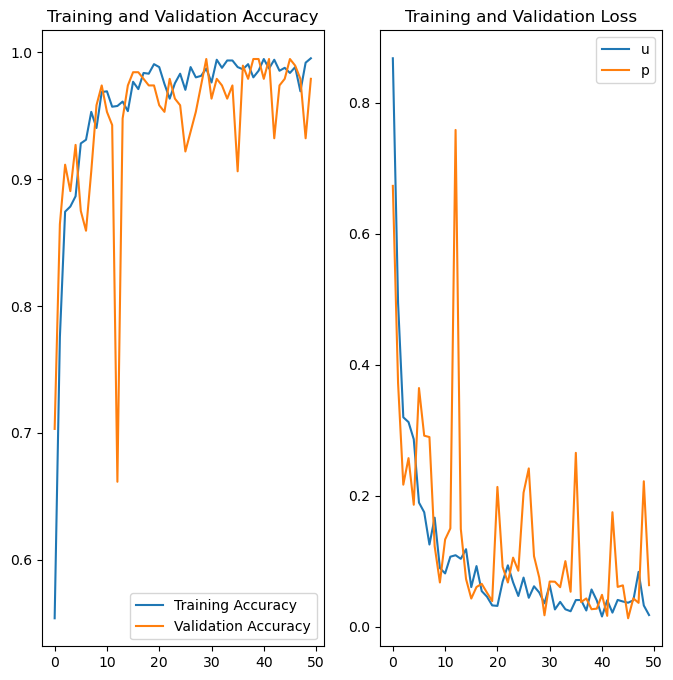

In [59]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHs), acc, label='Training Accuracy')
plt.plot(range(EPOCHs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHs), loss, label='Training Loss')
plt.plot(range(EPOCHs), val_loss, label='Validation Loss')
plt.legend('upper right')
plt.title('Training and Validation Loss')
plt.show()

2023-08-12 23:14:42.982341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 23:14:42.983834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]


first image to predict
First image's actual label:  Potato___Early_blight
1/1 [==============================] - 2s 2s/step
prediction results :  [9.9999994e-01 1.5366482e-11 1.4658197e-32]
predicted label is :  Potato___Early_blight


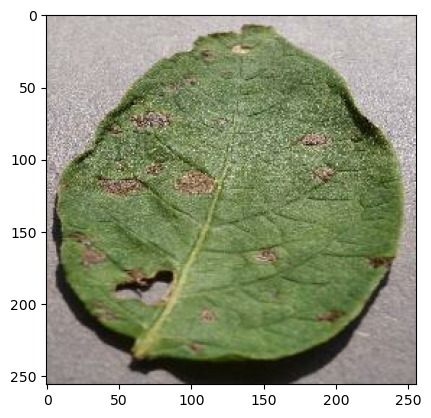

In [68]:
# Try prediction
for image_batch, labels_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[labels_batch[0]])

    batch_prediction = model.predict(image_batch)
    print("prediction results : ", batch_prediction[0])
    index_of_predicted_label = np.argmax(batch_prediction[0])
    print("predicted label is : ", class_names[index_of_predicted_label])

In [69]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

2023-08-12 23:37:32.633573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2152]
	 [[{{node Placeholder/_4}}]]
2023-08-12 23:37:32.636101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2152]
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 96ms/step


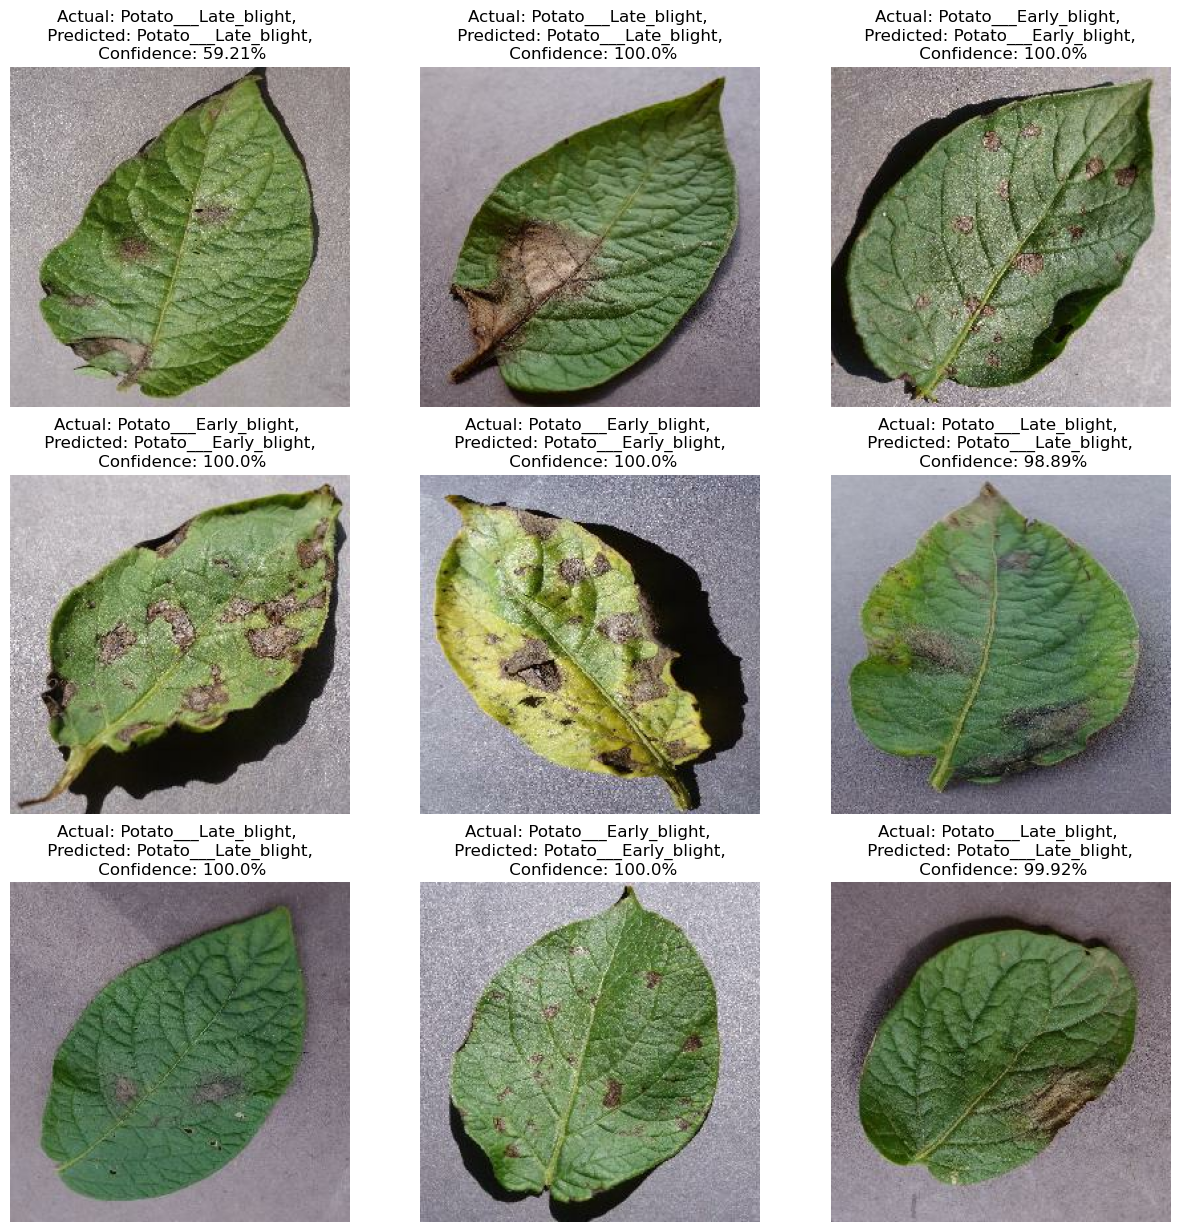

In [76]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images)
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis('off')

In [77]:
model_version=1
model.save(f"models/{model_version}")

2023-08-12 23:41:40.768256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_1_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_1_input}}]]
2023-08-12 23:41:41.098226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2023-08-12 23:41:41.119483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_1_input' with dtype float and s

INFO:tensorflow:Assets written to: models/1/assets


INFO:tensorflow:Assets written to: models/1/assets
